# Train Faster R-CNN
The following image describes the topology of the Faster R-CNN with FPN

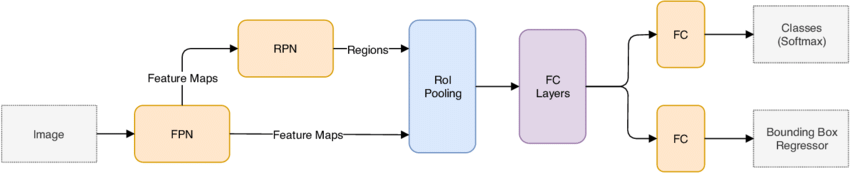

In [1]:
!pip install pandas matplotlib scikit-learn torchmetrics pycocotools

In [2]:
from typing import Tuple, List, Dict, Optional
from collections import OrderedDict
import os
import numpy as np
import pandas as pd
import json
import copy
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import tv_tensors
from torchvision.ops import box_convert

from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import Adam

from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers

from torchmetrics.detection import MeanAveragePrecision

## Datapreparation

#### Create target dataframe

In [3]:
data_dir = './dentex_dataset/origin/training_data/quadrant-enumeration-disease/xrays'
annotation_file = "./dentex_dataset/origin/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json"

with open(annotation_file, "r") as json_file:
    json_content = json.load(json_file)
    annotations = pd.DataFrame(json_content["annotations"]).set_index("id")
    images = pd.DataFrame(json_content["images"]).set_index("id")

# group py image id, rename and drop some cols
annotations = annotations \
    .drop(columns=['iscrowd', 'segmentation', 'area']) \
    .rename(columns={'category_id_1': 'quadrant', 'category_id_2': 'tooth_number','category_id_3': 'disease'}) \
    .groupby('image_id').agg(lambda x: x.tolist())

# convert to integer
annotations['bbox'] = annotations['bbox'].apply(lambda x: [np.array(sublist).astype(int) for sublist in x])

# merge with image metadata
target_df = pd.merge(annotations, images, left_on='image_id', right_on='id', how='left')
target_df

,bbox,quadrant,tooth_number,disease,height,width,file_name
0,"[[542, 698, 220, 271], [1952, 693, 177, 270], ...","[3, 2, 3, 2, 2, 2, 1, 0, 2, 2, 2, 2, 3]","[7, 7, 6, 2, 3, 4, 5, 6, 5, 6, 1, 0, 0]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]",1316,2744,train_673.png
1,"[[792, 980, 168, 165], [2013, 1049, 140, 135],...","[3, 2, 2, 1]","[7, 7, 6, 5]","[0, 0, 1, 1]",1504,2872,train_283.png
2,"[[843, 838, 190, 325], [1006, 826, 177, 345], ...","[3, 3, 3, 3, 2, 2, 0, 0, 1, 1, 1, 2, 1, 1]","[6, 5, 4, 3, 3, 6, 7, 6, 1, 4, 5, 4, 7, 6]","[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1]",1504,2872,train_95.png
3,"[[1082, 863, 109, 301], [1211, 891, 200, 298]]","[3, 3]","[3, 1]","[3, 2]",1504,2872,train_475.png
4,"[[1061, 504, 103, 298], [761, 464, 159, 240], ...","[0, 0, 1, 3, 3, 1]","[4, 7, 7, 4, 5, 4]","[1, 3, 1, 3, 3, 3]",1316,2867,train_62.png
...,...,...,...,...,...,...,...
673,"[[1795, 437, 208, 304], [1084, 781, 153, 268],...","[1, 3, 3, 3, 2]","[5, 4, 6, 7, 7]","[1, 1, 1, 0, 0]",1316,2910,train_338.png
674,"[[1916, 471, 127, 300], [1677, 795, 116, 279]]","[1, 2]","[6, 4]","[1, 1]",1316,2851,train_657.png
675,"[[1042, 418, 96, 293], [933, 423, 129, 284], [...","[0, 0, 1]","[4, 5, 6]","[3, 1, 1]",1316,2850,train_344.png
676,"[[2185, 855, 186, 310], [658, 454, 157, 356], ...","[2, 0, 3, 1, 2, 0, 1]","[7, 7, 6, 6, 4, 4, 3]","[0, 1, 1, 1, 1, 2, 2]",1504,2872,train_599.png


In [4]:
disease_dict = {
    0: "Impacted",
    1: "Caries",
    2: "Periapical Lesion",
    3: "Deep Caries"
}

In [5]:
def convert_bbox(bbox):
    return box_convert(torch.Tensor(bbox), 'xywh', 'xyxy')

def reverse_convert_bbox(bbox):
    return box_convert(torch.Tensor(bbox), 'xyxy', 'xywh')

In [6]:
def resize_bbox_xywh(bbox, old_size, new_size):
    x_scale = new_size[0] / old_size[0]
    y_scale = new_size[1] / old_size[1]
    
    return [bbox[0] * x_scale, bbox[1] * y_scale, bbox[2] * x_scale, bbox[3] * y_scale]

In [7]:
# test algorithm output [ X_min, Y_min, X_max, Y_max ]
height = 1316
width = 2744
[convert_bbox(resize_bbox_xywh(bbox, (width, height), (512,512) )) for bbox in target_df['bbox'][0]]

[tensor([101.1312, 271.5623, 142.1808, 376.9970]),
 tensor([364.2216, 269.6170, 397.2478, 374.6626]),
 tensor([125.9475, 275.4529, 171.2886, 392.1702]),
 tensor([272.9796, 282.0669, 291.2653, 447.4164]),
 tensor([286.6006, 292.9605, 305.8192, 441.1915]),
 tensor([298.5423, 296.4620, 321.3061, 427.5745]),
 tensor([317.3878, 144.3404, 344.4431, 257.1672]),
 tensor([145.3528, 146.2857, 169.9825, 269.6170]),
 tensor([311.0437, 281.2888, 355.2653, 419.7933]),
 tensor([336.9796, 270.7842, 381.2012, 390.6140]),
 tensor([262.1574, 281.6778, 276.1516, 419.0152]),
 tensor([250.7755, 280.1216, 265.1429, 429.9088]),
 tensor([240.3265, 281.2888, 251.8951, 431.8541])]

## Dataset

In [8]:
class RCNNDentexDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, target_df, image_size):
        self.root_dir = root_dir
        self.target_df = target_df
        self.image_size = image_size
        # Define transform
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])

        self.image_dict = {}
        # Iterate target df
        for idx, row in self.target_df.iterrows():
            file_path = os.path.join(self.root_dir, row['file_name'])
            # Check if target images exists
            if os.path.exists(file_path):
                self.image_dict[idx] = { 'image_path': file_path, 'bboxes': {}, 'labels': {} }
                # Encode Labels
                self.image_dict[idx]['labels'] = [
                    torch.tensor(disease, dtype=torch.int64)
                    for disease in row['disease']
                ] 
                # Convert and resize bounding boxes
                height = row['height']
                width = row['width']
                self.image_dict[idx]['bboxes'] = [
                    convert_bbox(
                        resize_bbox_xywh(bbox, (width, height), self.image_size
                    )) 
                    for bbox in row['bbox']
                ]

    def __len__(self):
        return len(self.image_dict)

    def __getitem__(self, idx):
        # Load & transform image
        img_path = self.image_dict[idx]['image_path']
        img = Image.open(img_path).convert("L")
        img = self.transform(img)

        # Get the targets
        target = {}
        target["boxes"] = self.image_dict[idx]['bboxes']
        target["labels"] = [label for label in self.image_dict[idx]['labels']]

        return img, target

#### Train test validation split

In [9]:
# Define the size of the validation and test sets
test_size = int(0.1 * len(target_df))  
val_size = int(0.15 * len(target_df))  
train_size = len(target_df) - val_size - test_size

# Extract the test dataset statically
test_df = target_df.iloc[len(target_df) - test_size:].reset_index()

# Split the remaining dataset randomly into training and validation sets
remaining_df = target_df.iloc[:len(target_df) - test_size]
train_df, val_df = train_test_split(remaining_df, train_size=train_size, shuffle=True)
val_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

In [10]:
len(train_df)

510

In [11]:
# Create dataloaders
BATCH_SIZE = 10 # Set as high as possible
NUM_WORKERS = 5

# Pad batch to have the same shape
def collate_fn(batch):
    max_num_boxes = max(len(item[1]) for item in batch)
    
    images = []
    targets = []
    
    for image, target in batch:
        images.append(image)
        
        # Pad target if it has fewer boxes
        if len(target) < max_num_boxes:
            target = np.pad(target, ((0, max_num_boxes - len(target)), (0, 0)), mode='constant')
        
        targets.append(target)
    
    # Convert each dictionary in targets to tensor
    targets = [{k: v for k, v in t.items()} for t in targets]
    
    return images, targets

# Create datasets
train_dataset = RCNNDentexDataset(root_dir=data_dir, target_df=train_df, image_size=(256,256))
val_dataset = RCNNDentexDataset(root_dir=data_dir, target_df=val_df, image_size=(256,256))
test_dataset = RCNNDentexDataset(root_dir=data_dir, target_df=test_df, image_size=(256,256))

# Define your data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

## Model

In [12]:
num_classes = len(disease_dict) + 1 # Background is also a class

In [13]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT") # for pretrained use weights="DEFAULT"

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
    
model = get_model_instance_segmentation(num_classes)

In [14]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

#### Eval helper method
Model does not output losses in eval mode - it needs to be comupted manually.  
Code source: https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch

In [15]:
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

## Hyperparameter search

In [16]:
def train_model(model, train_dataloader, validation_dataloader, optimizer, lr=1e-5, num_epochs=30, patience=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    increasing_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, targets in train_dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: torch.stack(v).to(device) if isinstance(v, list) else v.to(device) for k, v in t.items()} for t in targets]
            # format loss dict: {'loss_classifier': tensor(0.2335, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2740, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0672, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0671, device='cuda:0', grad_fn=<DivBackward0>)}
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            train_loss += losses.item()
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for images, targets in validation_dataloader:
                images = [image.to(device) for image in images]
                targets = [{k: torch.stack(v).to(device) if isinstance(v, list) else v.to(device) for k, v in t.items()} for t in targets]
                loss_dict, _ = eval_forward(model, images, targets)
                val_loss += sum(loss.sum().item() if loss.dim() else loss.item() for loss in loss_dict.values()) if loss_dict else 0
            avg_val_loss = val_loss / len(validation_dataloader)
            val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Early stopping and save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            increasing_epochs = 0
            torch.save(model.state_dict(), 'faster_rcnn_resnet50_fpn_v2_best_lr{}.pt'.format(lr))
        else:
            increasing_epochs += 1
            if increasing_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return model, train_losses, val_losses

In [17]:
def save_plot(train_losses, val_losses, lr):
    plt.figure(figsize=(12, 6))
    plt.title("Faster R-CNN ResNet-50 FPN V2@LR{}".format(lr))

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.tight_layout()

    plt.savefig('train_val_loss_lr{}.png'.format(lr), dpi=600)

In [18]:
def grid_search(model, train_dataloader, validation_dataloader, learning_rates, num_epochs=50, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        model_copy = copy.deepcopy(model)  # Create a copy of the model for each learning rate
        optimizer = torch.optim.Adam(model_copy.parameters(), lr=lr)
        trained_model, train_losses, val_losses = train_model(model_copy, train_dataloader, validation_dataloader, optimizer, lr, num_epochs, patience)
        print(f"Best validation loss for learning rate {lr}: {min(val_losses)}")
        save_plot(train_losses, val_losses, lr)

# Perform GridSearch
# grid_search(model, train_loader, val_loader, learning_rates=[1e-4, 1e-5, 1e-6, 5e-7, 3e-7, 1e-7])

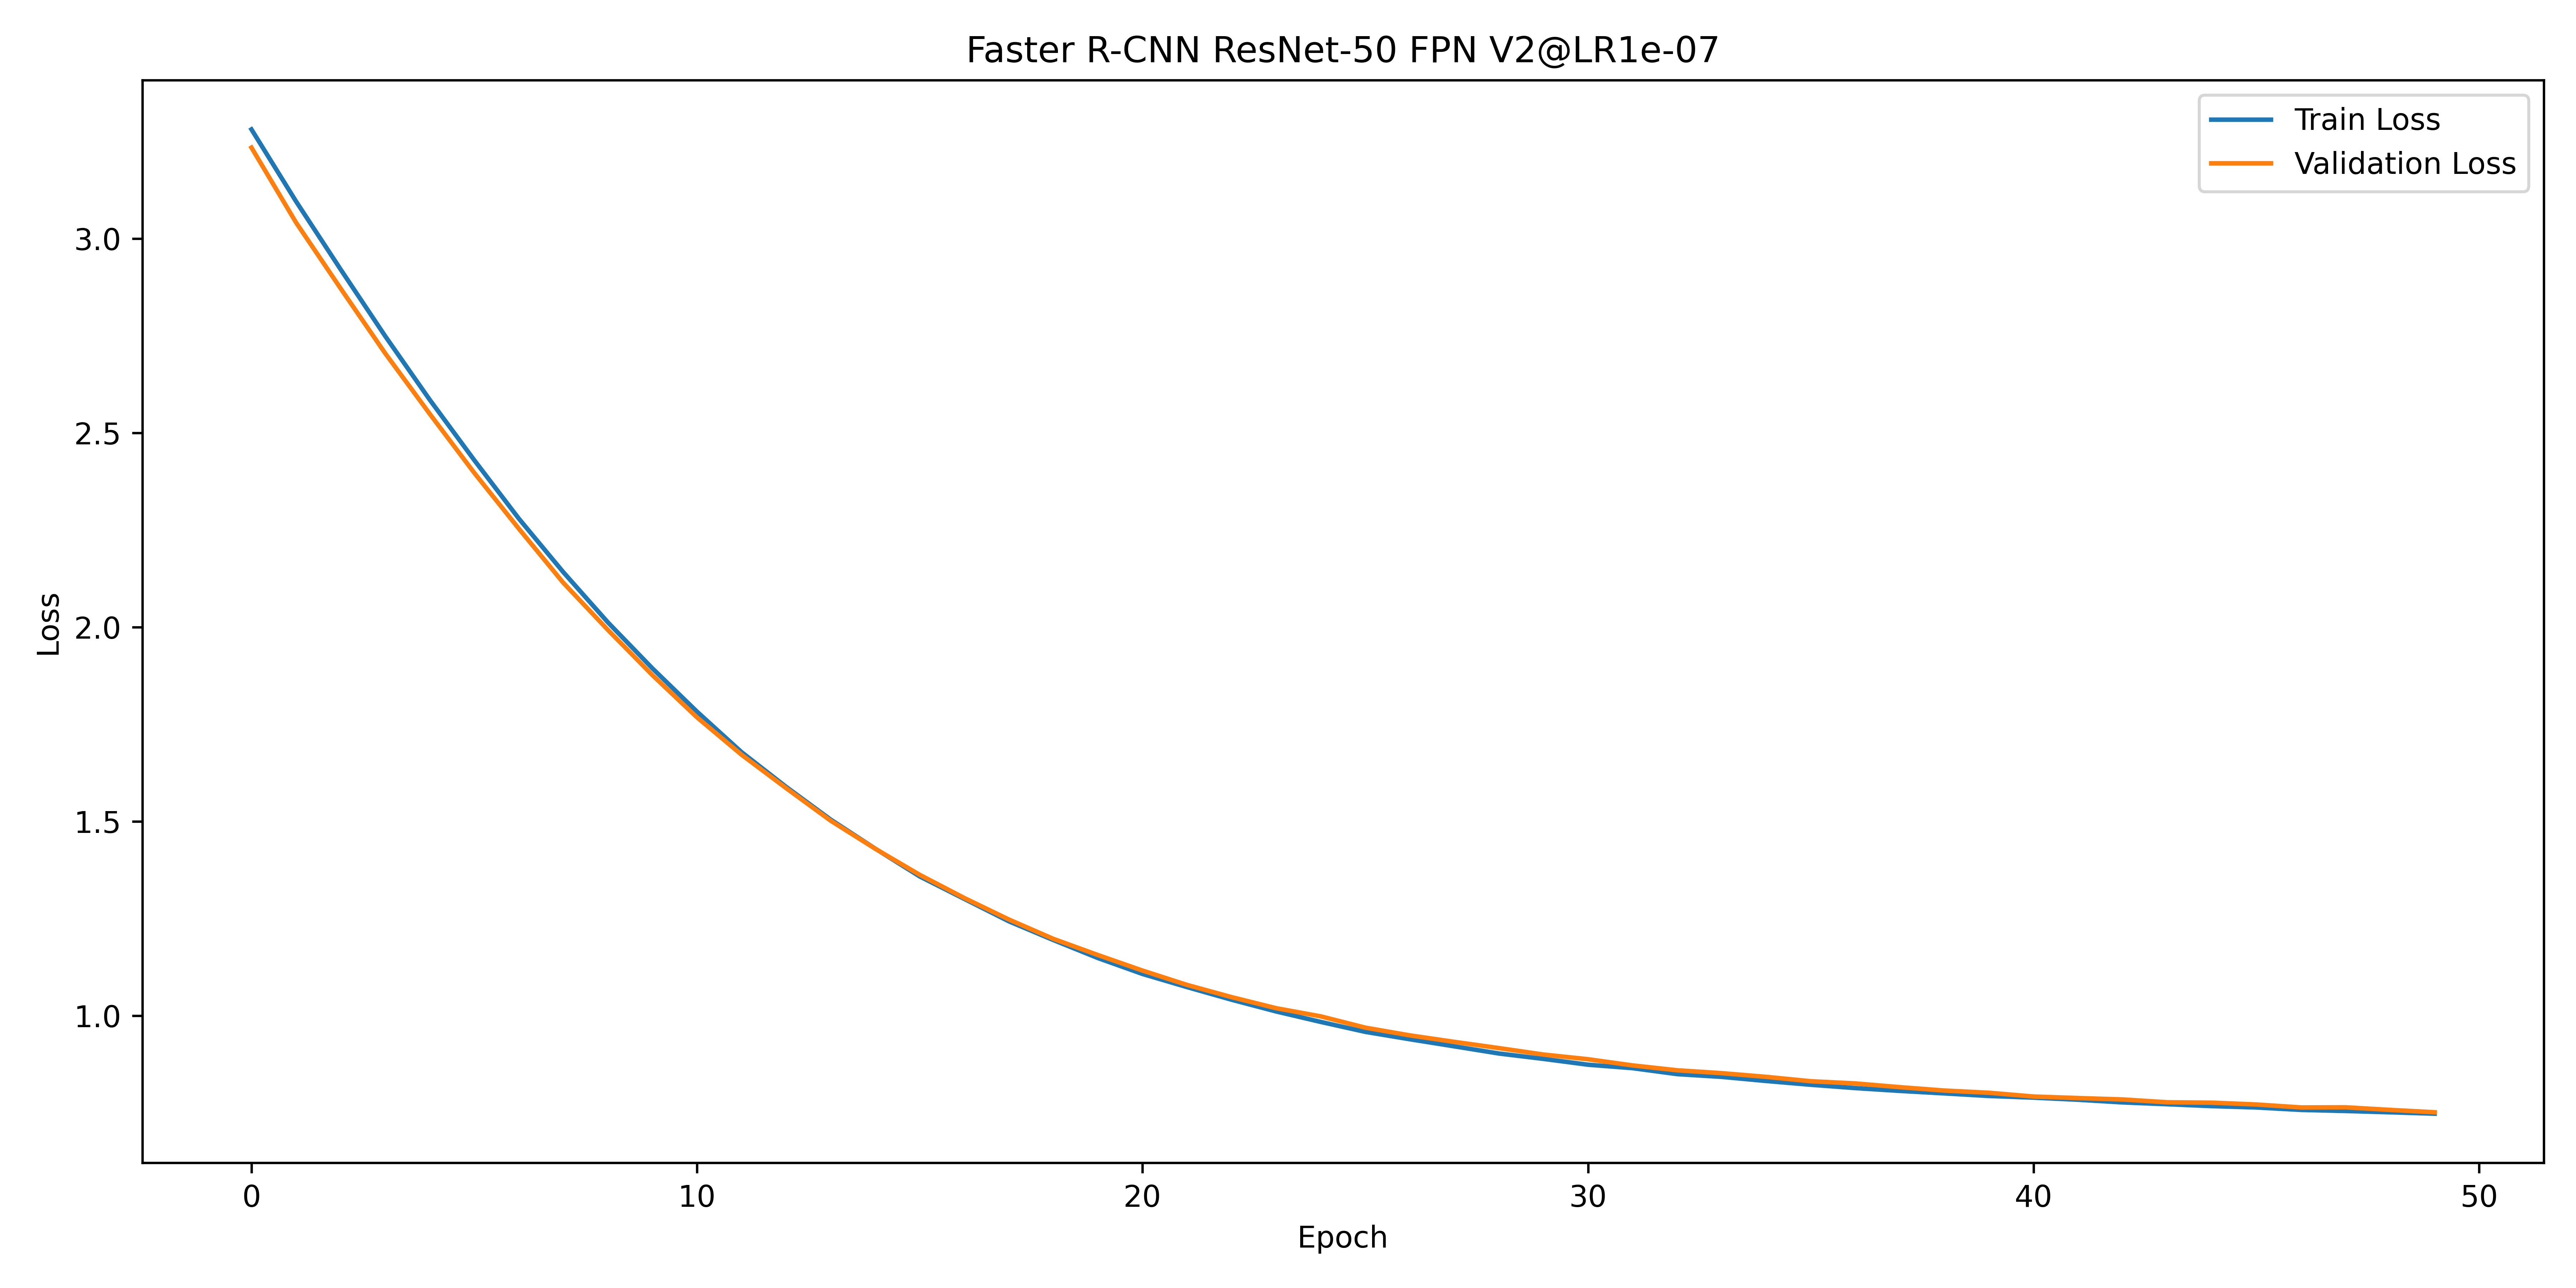

#### Facit
Showed that a learning rate of around `1e-7` is very good for transfer learning with Faster RCNN ResNET-50 FPN v2 as the validation and training loss decrease in a similar fashion.  
However the training needs to be >50 epochs as the best results was a validation loss of 0.42 with learing rate `1e-6`

## Training optimization

Different improvements:
- Successively reduce the learning rate with a scheduler
- Implemented data augmentation in the dataset
- See how the different losses evolve (`classifier`,`box_reg`, `objectness`, `rpn_box_reg`) &rarr; can be individually weighted for better convergance

In [19]:
initial_lr = 5e-6

model = get_model_instance_segmentation(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
# Linear scheduling
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    gamma=0.3,
    step_size=5,
    verbose=True
)

Adjusting learning rate of group 0 to 5.0000e-06.


In [20]:
def calculate_weighted_loss(loss_dict):
    # Ignore loss_box_reg -> See https://github.com/pytorch/vision/issues/1256
    return sum(loss for key, loss in loss_dict.items())

def append_losses(epoch_losses, loss_dict):
    epoch_losses['classifier'].append(loss_dict['loss_classifier'].item())
    epoch_losses['box_reg'].append(loss_dict['loss_box_reg'].item())
    epoch_losses['objectness'].append(loss_dict['loss_objectness'].item())
    epoch_losses['rpn_box_reg'].append(loss_dict['loss_rpn_box_reg'].item())
    return epoch_losses

def append_avg_epoch_losses(losses, epoch_losses, dataloader_len):
    avg_loss_classifier = np.sum(epoch_losses['classifier']) / dataloader_len
    avg_loss_box_reg = np.sum(epoch_losses['box_reg']) / dataloader_len
    avg_loss_objectness = np.sum(epoch_losses['objectness']) / dataloader_len
    avg_loss_rpn_box_reg = np.sum(epoch_losses['rpn_box_reg']) / dataloader_len

    losses['total'].append(avg_loss_classifier + avg_loss_box_reg + avg_loss_objectness + avg_loss_rpn_box_reg)
    losses['classifier'].append(avg_loss_classifier)
    losses['box_reg'].append(avg_loss_box_reg)
    losses['objectness'].append(avg_loss_objectness)
    losses['rpn_box_reg'].append(avg_loss_rpn_box_reg)

    return losses

def train_model(model, train_dataloader, validation_dataloader, optimizer, num_epochs, lr_scheduler=None, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_losses = {
        'total': [],
        'classifier': [],
        'box_reg': [],
        'objectness': [],
        'rpn_box_reg': []
    }
    val_losses = {
        'total': [],
        'classifier': [],
        'box_reg': [],
        'objectness': [],
        'rpn_box_reg': []
    }
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_epoch_losses = {
            'classifier': [],
            'box_reg': [],
            'objectness': [],
            'rpn_box_reg': []
        }

        for images, targets in train_dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: torch.stack(v).to(device) if isinstance(v, list) else v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = calculate_weighted_loss(loss_dict)
            losses.backward()
            optimizer.step()
            train_epoch_losses = append_losses(train_epoch_losses, loss_dict)
        if lr_scheduler:
                lr_scheduler.step()
        train_losses = append_avg_epoch_losses(train_losses, train_epoch_losses, len(train_dataloader))

        # Validation
        model.eval()
        with torch.no_grad():
            val_epoch_losses = {
                'classifier': [],
                'box_reg': [],
                'objectness': [],
                'rpn_box_reg': []
            }
            for images, targets in validation_dataloader:
                images = [image.to(device) for image in images]
                targets = [{k: torch.stack(v).to(device) if isinstance(v, list) else v.to(device) for k, v in t.items()} for t in targets]
                loss_dict, _ = eval_forward(model, images, targets)
                val_epoch_losses = append_losses(val_epoch_losses, loss_dict)
        val_losses = append_avg_epoch_losses(val_losses, val_epoch_losses, len(validation_dataloader))
        print(f"Epoch {epoch+1}/{num_epochs} - Total Training Loss: {train_losses['total'][-1]} Total Validation Loss: {val_losses['total'][-1]}")

        # Early stopping and save best model
        if val_losses['total'][-1] < best_val_loss:
            best_val_loss = val_losses['total'][-1]
            increasing_epochs = 0
            torch.save(model.state_dict(), 'faster_rcnn_resnet50_fpn_v2_best.pt')
        else:
            increasing_epochs += 1
            if increasing_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return model, train_losses, val_losses

In [21]:
num_epochs = 20
patience = 3

model, train_losses, val_losses = train_model(
    model=model,
    train_dataloader=train_loader,
    validation_dataloader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    lr_scheduler=lr_scheduler,
    patience=patience
)

Adjusting learning rate of group 0 to 5.0000e-06.
Epoch 1/20 - Total Training Loss: 1.3396068887748553 Total Validation Loss: 0.8969372629441997
Adjusting learning rate of group 0 to 5.0000e-06.
Epoch 2/20 - Total Training Loss: 0.8445168107236718 Total Validation Loss: 0.6806494524194435
Adjusting learning rate of group 0 to 5.0000e-06.
Epoch 3/20 - Total Training Loss: 0.6067524685469621 Total Validation Loss: 0.6190476746044374
Adjusting learning rate of group 0 to 5.0000e-06.
Epoch 4/20 - Total Training Loss: 0.5680130907316125 Total Validation Loss: 0.5531128832901065
Adjusting learning rate of group 0 to 1.5000e-06.
Epoch 5/20 - Total Training Loss: 0.5155708964585382 Total Validation Loss: 0.5682622903788632
Adjusting learning rate of group 0 to 1.5000e-06.
Epoch 6/20 - Total Training Loss: 0.506156932434761 Total Validation Loss: 0.5223063579337163
Adjusting learning rate of group 0 to 1.5000e-06.
Epoch 7/20 - Total Training Loss: 0.47670110720483694 Total Validation Loss: 0.50

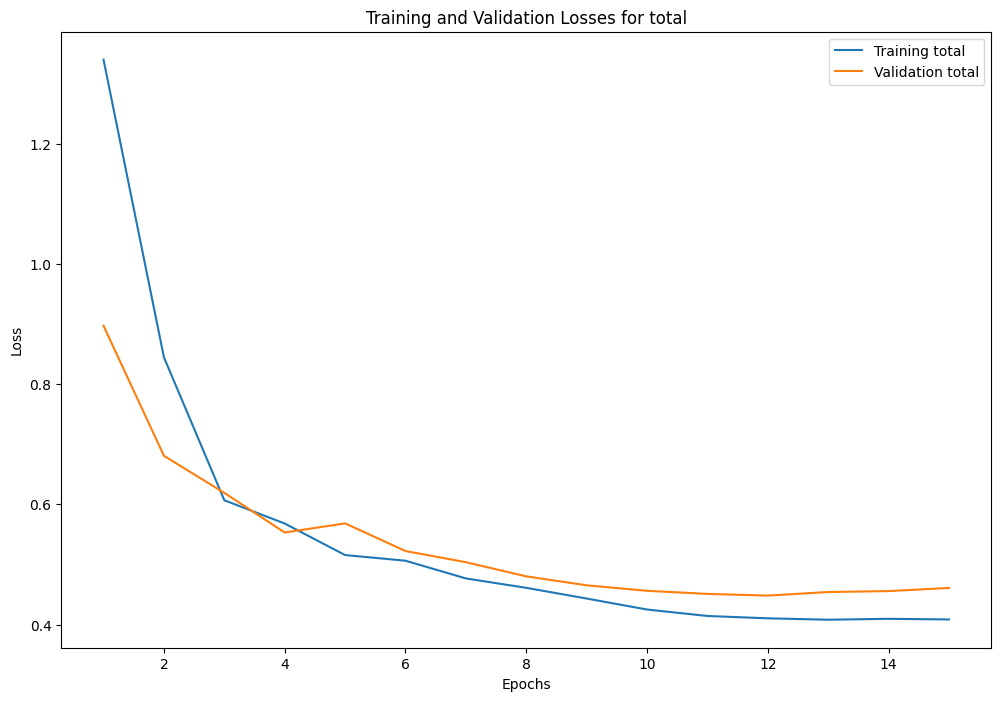

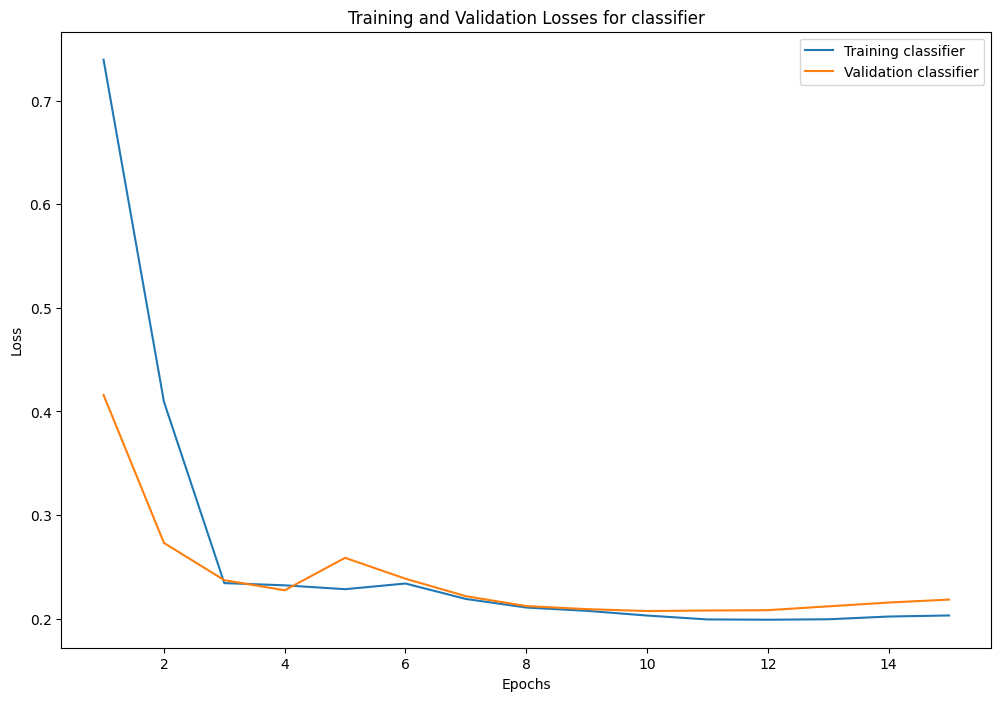

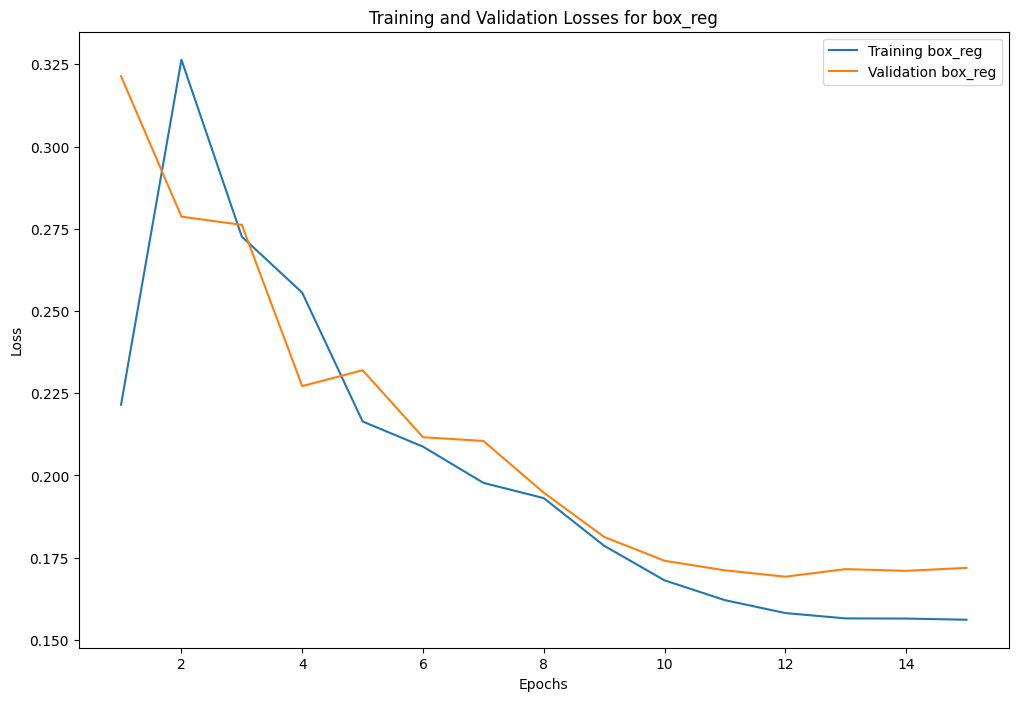

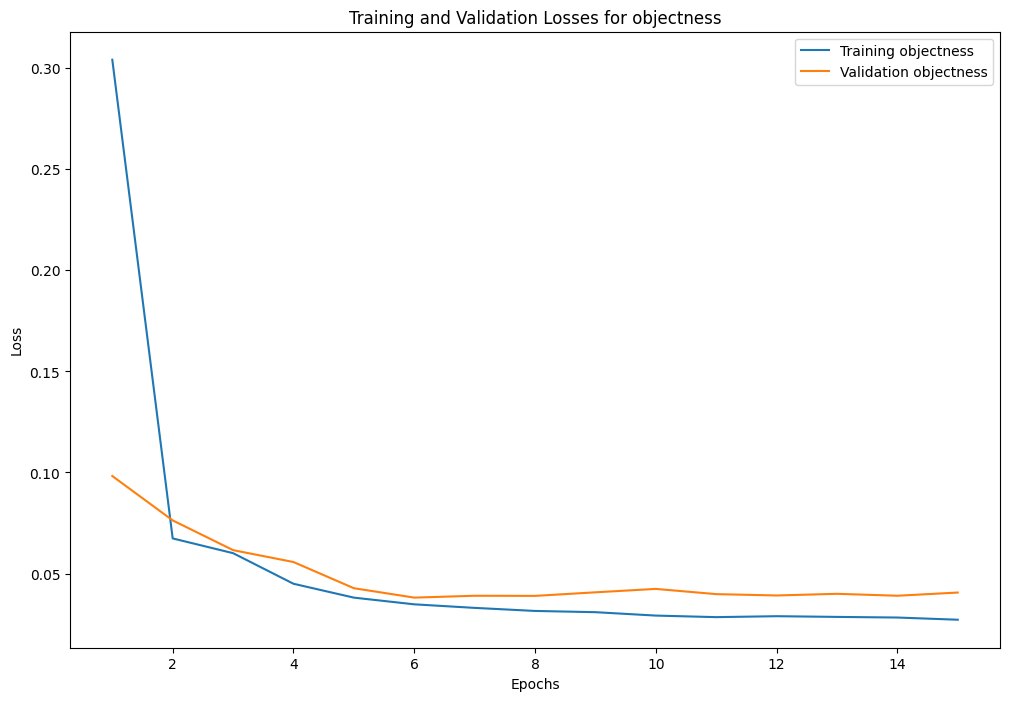

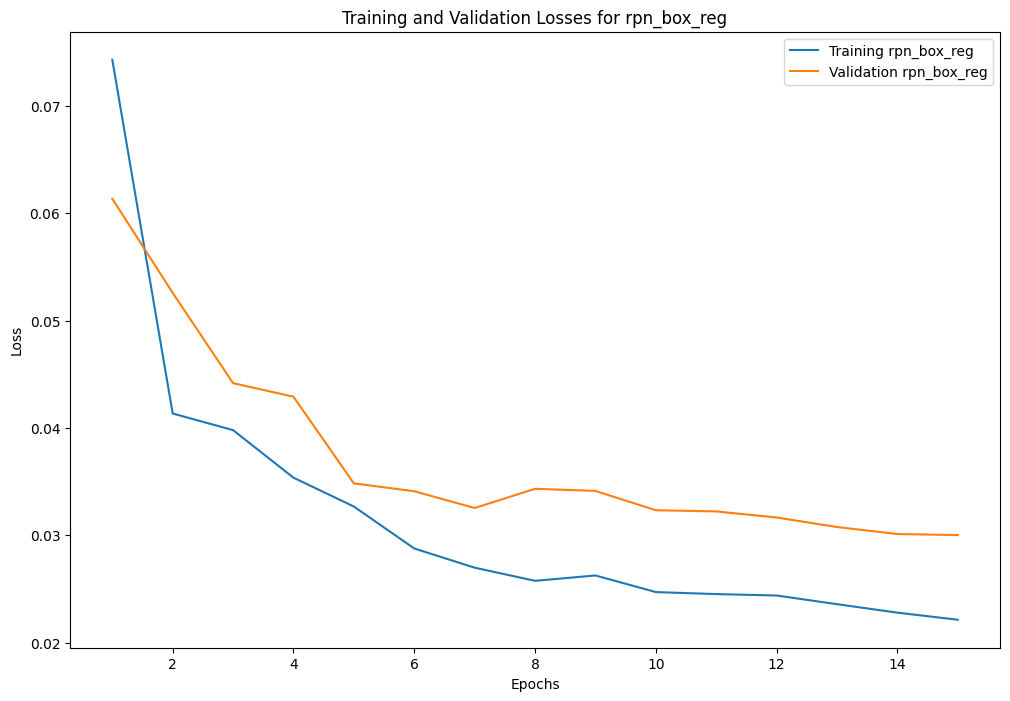

In [22]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses['classifier']) + 1)

    for loss_name in train_losses.keys():
        plt.figure(figsize=(12, 8))  # Move this line inside the loop
        plt.plot(epochs, train_losses[loss_name], label=f'Training {loss_name}')
        plt.plot(epochs, val_losses[loss_name], label=f'Validation {loss_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses for {loss_name}')
        plt.legend()
        plt.savefig('train_val_loss_{}.png'.format(loss_name), dpi=600)

# Call the function
plot_losses(train_losses, val_losses)

#### Facit
All the losses go down in a similar manner, except box_reg but apparently this is normal. See [here](https://github.com/pytorch/vision/issues/1256)

## Check Output

In [23]:
# Load the model
model_path = './faster_rcnn_resnet50_fpn_v2_best.pt'
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load(model_path))
model.to('cuda')

# Load the miage
image_path = './dentex_dataset/segmentation/enumeration32/xrays/train_4.png'
image = Image.open(image_path).convert("L")
width, height = image.size

# Load true values
true_labels = target_df.loc[target_df['file_name'] == 'train_4.png']['disease'].values[0]
true_bboxes = [convert_bbox(bbox) for bbox in target_df.loc[target_df['file_name'] == 'train_4.png']['bbox'].values[0]]
true_scores = np.full(len(true_labels), 100)

# Convert the image to PyTorch tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image_tensor = transform(image)

# Add an extra dimension because the model expects batches
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to('cuda')

# Get the model's output
model.eval()
output = model(image_tensor)[0]

# Get the bounding boxes, labels and scores from the model's output
boxes = output['boxes'].detach().cpu().numpy()
labels = output['labels'].detach().cpu().numpy()
scores = output['scores'].detach().cpu().numpy()

# Calculate Original bounding boxes
original_boxes = [
    resize_bbox_xywh(
        bbox,
        (256,256),
        (width, height))
    for bbox in boxes]

transform = transforms.Compose([
    transforms.ToTensor()
])

original_image = transform(image)
original_image = original_image.unsqueeze(0)
original_image = original_image.to('cuda')

In [24]:
# Filter score theshold
scores = scores[scores >= 0.50]
n = len(scores)
labels = labels[:n]
original_boxes = original_boxes[:n]

In [25]:
true_labels

[3, 1]

In [26]:
labels

array([1, 1, 1, 1, 1])

In [27]:
disease_dict

{0: 'Impacted', 1: 'Caries', 2: 'Periapical Lesion', 3: 'Deep Caries'}

In [28]:
def show_image(image_tensor, boxes, labels, scores):
    color_map={ 0: 'c', 1: 'y', 2: 'g', 3: 'b'}
    
    # Convert the image tensor back to numpy array
    image_array = image_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()

    # Create a matplotlib figure with a large size
    fig, ax = plt.subplots(1, figsize=(15, 15))
    
    # Display the image
    ax.imshow(np.clip(image_array, 0, 1), cmap='gray')

    # Draw each bounding box
    for box, label, score in zip(boxes, labels, scores):
        # Get the color for this label
        color = color_map.get(label, 'r')  # Default to 'r' if label not in color_map

        # Create a Rectangle patch
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=color, facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add label and score text
        plt.text(box[0], box[1], f'{disease_dict[label]}: {score:.2f}', color=color)

    # Show the figure
    plt.show()

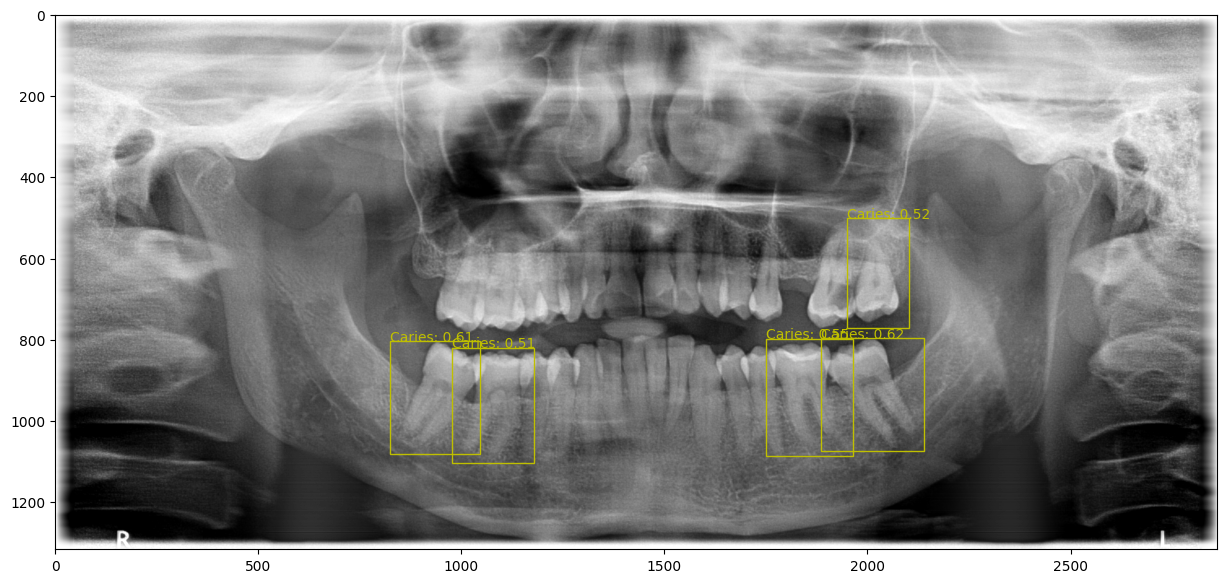

In [29]:
show_image(original_image, original_boxes, labels, scores)

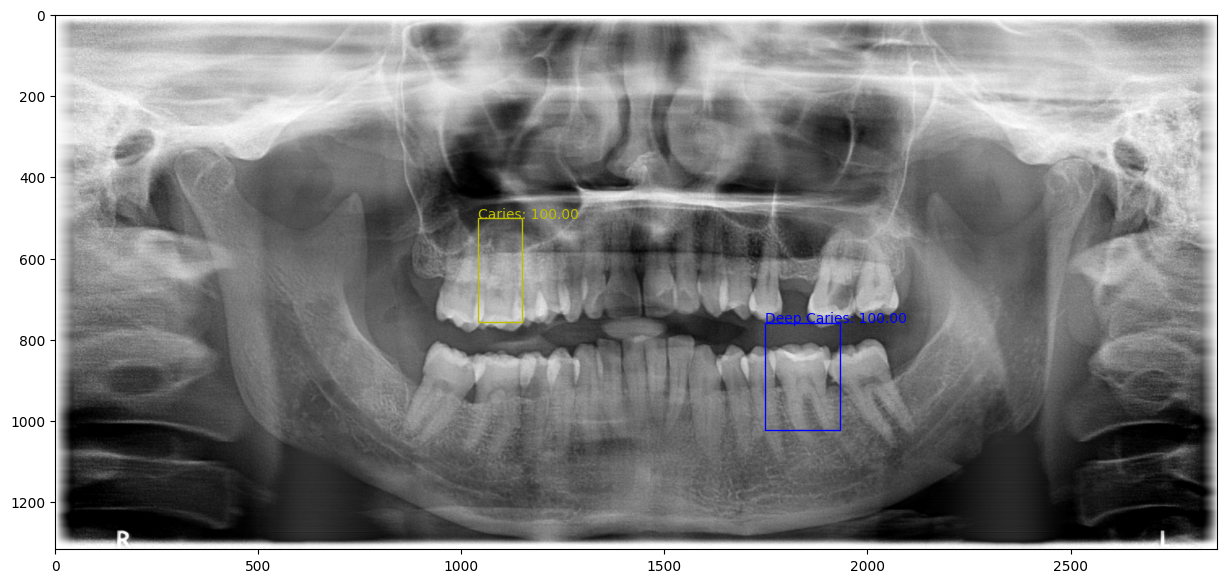

In [30]:
show_image(original_image, true_bboxes, true_labels, true_scores)

## Evaluation

In [15]:
len(test_loader.dataset)

67

In [16]:
model_path = './faster_rcnn_resnet50_fpn_v2_best.pt'
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

metric = MeanAveragePrecision(iou_type="bbox", box_format="xywh", class_metrics=True)

for images, targets in test_loader:
    torch.cuda.empty_cache()
    images = [image.to(device) for image in images]
    targets = [{k: torch.stack(v).to(device) if isinstance(v, list) else v.to(device) for k, v in t.items()} for t in targets]
    output = model(images) 
    # prevent CUDA OOM
    preds = [
        {
        'boxes': o['boxes'].detach(),
        'labels': o['labels'].detach(),
        'scores': o['scores'].detach()
        }
    for o in output]
    metric.update(preds, targets)

metric.compute()

{'map': tensor(0.0917),
 'map_50': tensor(0.1258),
 'map_75': tensor(0.0914),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.2088),
 'map_large': tensor(0.0916),
 'mar_1': tensor(0.0779),
 'mar_10': tensor(0.4154),
 'mar_100': tensor(0.5025),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.5250),
 'mar_large': tensor(0.5036),
 'map_per_class': tensor([0.0000, 0.2829, 0.0097, 0.0741]),
 'mar_100_per_class': tensor([0.0000, 0.9276, 0.2000, 0.8825]),
 'classes': tensor([0, 1, 2, 3], dtype=torch.int32)}

In [18]:
disease_dict

{0: 'Impacted', 1: 'Caries', 2: 'Periapical Lesion', 3: 'Deep Caries'}

#### Manual evalution

In [17]:
model_path = './faster_rcnn_resnet50_fpn_v2_best.pt'
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load(model_path))
model.to('cuda')

metric = MeanAveragePrecision(iou_type="bbox", box_format="xywh", class_metrics=True)

# Load the miage
image_path = './dentex_dataset/segmentation/enumeration32/xrays/train_4.png'
image = Image.open(image_path).convert("L")
width, height = image.size

# Load true values
true_labels = target_df.loc[target_df['file_name'] == 'train_4.png']['disease'].values[0]
true_bboxes = [convert_bbox(bbox) for bbox in target_df.loc[target_df['file_name'] == 'train_4.png']['bbox'].values[0]]
true_scores = np.full(len(true_labels), 100)

# Convert the image to PyTorch tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image_tensor = transform(image)

# Add an extra dimension because the model expects batches
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to('cuda')

# Get the model's output
model.eval()
output = model(image_tensor)[0]

boxes = output['boxes'].detach().cpu()
labels = output['labels'].detach().cpu()
scores = output['scores'].detach().cpu()

# Calculate Original bounding boxes
original_boxes = torch.tensor([
        resize_bbox_xywh(
            bbox,
            (256,256),
            (width, height))
    for bbox in boxes])

preds = [{
    'boxes': original_boxes,
    'labels': labels,
    'scores': scores
}]

target = [{
    'boxes': torch.stack(true_bboxes),
    'labels': torch.tensor(true_labels),
}]

metric.update(preds, target)
metric.compute()

{'map': tensor(0.3688),
 'map_50': tensor(0.5625),
 'map_75': tensor(0.2917),
 'map_small': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_large': tensor(0.3688),
 'mar_1': tensor(0.2500),
 'mar_10': tensor(0.6500),
 'mar_100': tensor(0.8000),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(0.8000),
 'map_per_class': tensor([ 0.0875, -1.0000,  0.6500]),
 'mar_100_per_class': tensor([ 0.8000, -1.0000,  0.8000]),
 'classes': tensor([1, 2, 3], dtype=torch.int32)}